<a href="https://colab.research.google.com/github/Evolved360/Neural-Inc/blob/main/Feature_engineering_and_Model_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install relevant packages
!pip install CBFV
!pip install matminer
!pip install scikit-learn==1.0.2
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.11 requires scikit-learn>=1.3.2, but you have scikit-learn 1.0.2 which is incompatible.
bigframes 1.11.1 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
# Import all relevant libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import CBFV
import shap
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
# from matminer.featurizers.conversions import StrToComposition
# from matminer.featurizers.composition import ElementPropertyFeaturizer
from CBFV.composition import generate_features as gf
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
%matplotlib inline

In [152]:
# Import extracted battery data
Li_data = pd.read_csv('Li_data.csv')
Ca_data = pd.read_csv('Ca_data.csv')
Mg_data = pd.read_csv('Mg_data.csv')
Cs_data = pd.read_csv('Cs_data.csv')
K_data = pd.read_csv('K_data.csv')
Na_data = pd.read_csv('Na_data.csv')
Al_data = pd.read_csv('Al_data.csv')
Rb_data = pd.read_csv('Rb_data.csv')
Y_data = pd.read_csv('Y_data.csv')
Zn_data = pd.read_csv('Zn_data.csv')

In [153]:
# Combine the imported data
battery_data = pd.concat([Li_data, Ca_data, Mg_data, Cs_data, K_data, Na_data, Al_data, Rb_data, Y_data, Zn_data])
battery_data.reset_index(drop = True, inplace = True)
battery_data.to_csv('battery_data.csv', index=False)

# Display the data
battery_data.head()

,battery_type,battery_id,thermo_type,battery_formula,working_ion,num_steps,max_voltage_step,last_updated,framework,framework_formula,...,band_gap_charge,band_gap_discharge,energy_above_hull_charge,energy_above_hull_discharge,ordering_charge,ordering_discharge,density_atomic_charge,density_atomic_discharge,symmetry_charge,symmetry_discharge
0,NaN,mp-757871_Li,NaN,Li2-4CoNi3O8,Li,2,0.221134,2022-06-28 03:50:55.322,Co1 Ni3 O8,CoNi3O8,...,0.0000,0.0728,0.033696,0.005797,FM,FiM,9.780880,8.632508,crystal_system=<CrystalSystem.tri: 'Triclinic'...,crystal_system=<CrystalSystem.mono: 'Monoclini...
1,NaN,mp-755220_Li,NaN,Li3-4CrNi3O8,Li,1,0.000000,2022-06-28 03:50:55.322,Cr1 Ni3 O8,CrNi3O8,...,0.0000,0.0000,0.089458,0.038080,FM,FiM,9.402367,8.782453,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.trig: 'Trigonal'...
2,NaN,mp-762224_Li,NaN,Li0-4Cu3Sb(PO4)4,Li,1,0.000000,2022-06-28 03:50:55.322,Cu3 Sb1 P4 O16,Cu3Sb(PO4)4,...,0.0022,0.0000,0.069619,0.072188,FiM,FM,12.005144,11.102137,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.mono: 'Monoclini...
3,NaN,mp-759472_Li,NaN,Li1-2Cu(HO)4,Li,1,0.000000,2022-06-28 03:50:55.322,Cu1 H4 O4,Cu(HO)4,...,1.4109,0.0000,0.081335,0.079091,NM,FM,8.802994,7.809873,crystal_system=<CrystalSystem.ortho: 'Orthorho...,crystal_system=<CrystalSystem.ortho: 'Orthorho...
4,NaN,mp-772496_Li,NaN,Li0-4Mn3CuNi2(PO4)6,Li,1,0.000000,2022-06-28 03:50:55.322,Mn3 Cu1 Ni2 P6 O24,Mn3CuNi2(PO4)6,...,0.0000,0.0000,0.046100,0.083395,FM,FiM,11.945197,11.517088,crystal_system=<CrystalSystem.trig: 'Trigonal'...,crystal_system=<CrystalSystem.tri: 'Triclinic'...


In [154]:
# Create a list of redundant columns
# irrelevant_columns = ['battery_type', 'battery_id', 'thermo_type', 'last_updated', 'id_charge', 'id_discharge', 'host_structure', 'adj_pairs',
                    #  'material_ids', 'entries_composition_summary', 'electrode_object', 'fields_not_requested', 'elements', 'framework', 'warnings',
                  #  'formula_charge', 'formula_discharge', 'formula_anonymous', 'chemsys', 'battery_formula']

irrelevant_columns = ['battery_type', 'thermo_type', 'last_updated', 'elements', 'warnings','adj_pairs', 'entries_composition_summary']
# # Remove redundant columns
battery_data.drop(irrelevant_columns, axis=1, inplace=True)

# # Display the cleaned data
battery_data.head()

,battery_id,battery_formula,working_ion,num_steps,max_voltage_step,framework,framework_formula,nelements,chemsys,formula_anonymous,...,band_gap_charge,band_gap_discharge,energy_above_hull_charge,energy_above_hull_discharge,ordering_charge,ordering_discharge,density_atomic_charge,density_atomic_discharge,symmetry_charge,symmetry_discharge
0,mp-757871_Li,Li2-4CoNi3O8,Li,2,0.221134,Co1 Ni3 O8,CoNi3O8,3,Co-Ni-O,AB3C8,...,0.0000,0.0728,0.033696,0.005797,FM,FiM,9.780880,8.632508,crystal_system=<CrystalSystem.tri: 'Triclinic'...,crystal_system=<CrystalSystem.mono: 'Monoclini...
1,mp-755220_Li,Li3-4CrNi3O8,Li,1,0.000000,Cr1 Ni3 O8,CrNi3O8,3,Cr-Ni-O,AB3C8,...,0.0000,0.0000,0.089458,0.038080,FM,FiM,9.402367,8.782453,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.trig: 'Trigonal'...
2,mp-762224_Li,Li0-4Cu3Sb(PO4)4,Li,1,0.000000,Cu3 Sb1 P4 O16,Cu3Sb(PO4)4,4,Cu-O-P-Sb,AB3C4D16,...,0.0022,0.0000,0.069619,0.072188,FiM,FM,12.005144,11.102137,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.mono: 'Monoclini...
3,mp-759472_Li,Li1-2Cu(HO)4,Li,1,0.000000,Cu1 H4 O4,Cu(HO)4,3,Cu-H-O,AB4C4,...,1.4109,0.0000,0.081335,0.079091,NM,FM,8.802994,7.809873,crystal_system=<CrystalSystem.ortho: 'Orthorho...,crystal_system=<CrystalSystem.ortho: 'Orthorho...
4,mp-772496_Li,Li0-4Mn3CuNi2(PO4)6,Li,1,0.000000,Mn3 Cu1 Ni2 P6 O24,Mn3CuNi2(PO4)6,5,Cu-Mn-Ni-O-P,AB2C3D6E24,...,0.0000,0.0000,0.046100,0.083395,FM,FiM,11.945197,11.517088,crystal_system=<CrystalSystem.trig: 'Trigonal'...,crystal_system=<CrystalSystem.tri: 'Triclinic'...


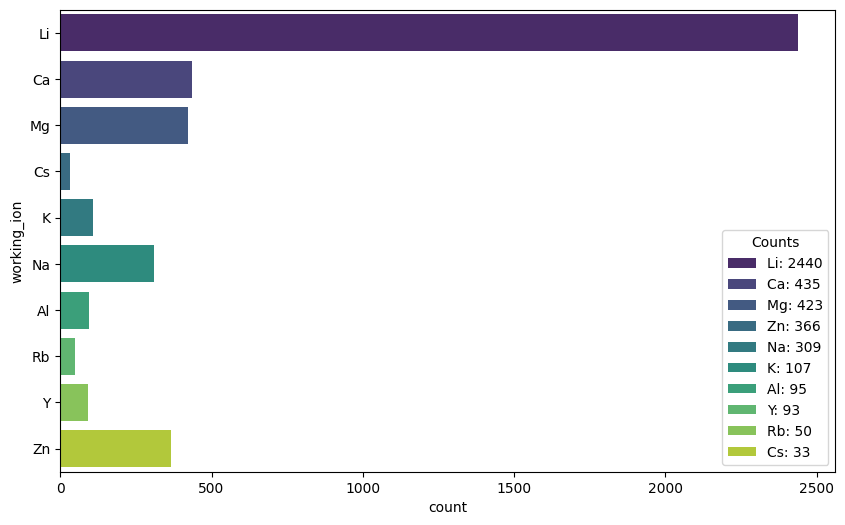

In [155]:
#Create a bar chart to visualize the number of working ions for each electrode
plt.figure(figsize=(10, 6))
ax = sns.countplot(battery_data['working_ion'], palette='viridis')

# Get the unique categories and their counts
categories = battery_data['working_ion'].value_counts().index.tolist()
counts = battery_data['working_ion'].value_counts().tolist()

# Create custom legend
legend_labels = [f'{cat}: {count}' for cat, count in zip(categories, counts)]
ax.legend(handles=ax.patches, labels=legend_labels, title='Counts')

<Axes: >

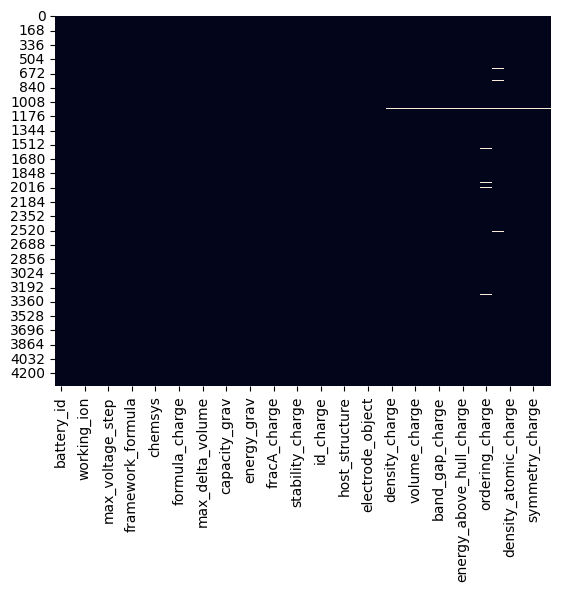

In [156]:
# Display missing battery data
sns.heatmap(battery_data.isnull(), cbar=False)

<Axes: >

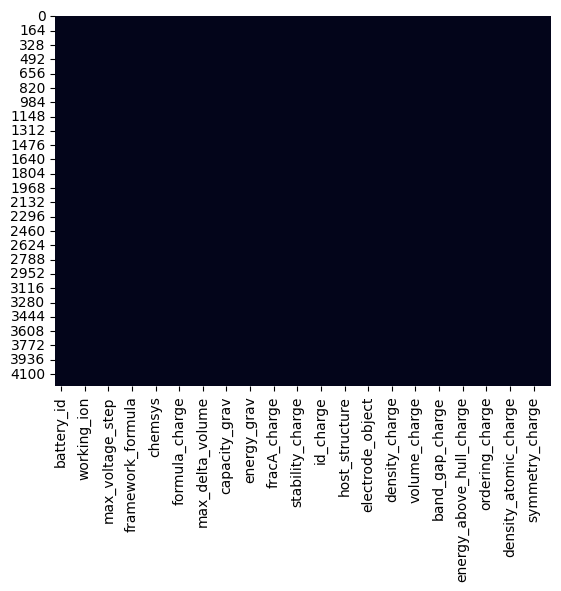

In [157]:
# Remove missing data
battery_data.dropna(inplace=True)
battery_data.reset_index(drop = True, inplace = True)

# Display heatmap without missing data
sns.heatmap(battery_data.isnull(), cbar=False)

# **FEATURIZATION**

In [158]:
def parse_formula(formula):
    elements = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    composition = {}
    for (element, count) in elements:
        if count == '':
            count = 1
        else:
            count = int(count)
        if element in composition:
            composition[element] += count
        else:
            composition[element] = count
    return composition

In [159]:
compositions = battery_data['framework_formula'].apply(parse_formula)
composition_df = pd.DataFrame(compositions.tolist()).fillna(0)
battery_data = pd.concat([battery_data, composition_df], axis=1)

In [160]:
composition_df.columns

Index(['Co', 'Ni', 'O', 'Cr', 'Cu', 'Sb', 'P', 'H', 'Mn', 'V', 'Fe', 'S', 'In',
       'Se', 'Ti', 'B', 'Ho', 'Si', 'Te', 'Ru', 'La', 'Er', 'Tl', 'W', 'F',
       'Ge', 'C', 'Nb', 'Rh', 'Dy', 'Ga', 'Lu', 'Zn', 'Ta', 'Pt', 'Sn', 'Pb',
       'Hg', 'Nd', 'Mo', 'Eu', 'Sm', 'Sc', 'N', 'Zr', 'Re', 'Y', 'As', 'Au',
       'Bi', 'Cl', 'Al', 'Ag', 'Pd', 'Cd', 'Tb', 'Pr', 'Hf', 'U', 'Ir', 'Gd',
       'I', 'Br', 'Ce', 'Tc'],
      dtype='object')

In [161]:
ionic_radii = {'Li': 76,
               'Ca': 100,
               'Mg': 72,
               'Cs': 260,
               'K': 138,
               'Na': 102,
               'Al': 53.5,
               'Rb': 152,
               'Y': 90,
               'Zn': 74}
def get_ionic_radius(working_ion):
    return ionic_radii.get(working_ion, 0)

atomic_mass = {'Li': 6.94,
               'Ca': 40.08,
               'Mg': 24.31,
               'Cs': 132.91,
               'K': 39.10,
               'Na': 23.00,
               'Al': 26.98,
               'Rb': 85.47,
               'Y': 88.91,
               'Zn': 65.40}
def get_atomic_mass(working_ion):
    return atomic_mass.get(working_ion, 0)

In [162]:
battery_data['ionic_radius'] = battery_data['working_ion'].apply(get_ionic_radius)
battery_data['atomic_mass'] = battery_data['working_ion'].apply(get_atomic_mass)

In [163]:
battery_data[['working_ion', 'ionic_radius', 'atomic_mass']]

,working_ion,ionic_radius,atomic_mass
0,Li,76.0,6.94
1,Li,76.0,6.94
2,Li,76.0,6.94
3,Li,76.0,6.94
4,Li,76.0,6.94
...,...,...,...
4233,Zn,74.0,65.40
4234,Zn,74.0,65.40
4235,Zn,74.0,65.40
4236,Zn,74.0,65.40


In [164]:
battery_data[['id_charge', 'id_discharge', 'symmetry_charge', 'symmetry_discharge']].head(10)

,id_charge,id_discharge,symmetry_charge,symmetry_discharge
0,mp-1178027,mp-867640,crystal_system=<CrystalSystem.tri: 'Triclinic'...,crystal_system=<CrystalSystem.mono: 'Monoclini...
1,mp-755220,mp-757137,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.trig: 'Trigonal'...
2,mp-780043,mp-762224,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.mono: 'Monoclini...
3,mp-759472,mp-769242,crystal_system=<CrystalSystem.ortho: 'Orthorho...,crystal_system=<CrystalSystem.ortho: 'Orthorho...
4,mp-772496,mp-775323,crystal_system=<CrystalSystem.trig: 'Trigonal'...,crystal_system=<CrystalSystem.tri: 'Triclinic'...
5,mp-768676,mp-754209,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.mono: 'Monoclini...
6,mp-755017,mp-756121,crystal_system=<CrystalSystem.mono: 'Monoclini...,crystal_system=<CrystalSystem.mono: 'Monoclini...
7,mp-753211,mp-755288,crystal_system=<CrystalSystem.trig: 'Trigonal'...,crystal_system=<CrystalSystem.trig: 'Trigonal'...
8,mp-754509,mp-753536,crystal_system=<CrystalSystem.ortho: 'Orthorho...,crystal_system=<CrystalSystem.ortho: 'Orthorho...
9,mp-1078168,mp-1079491,crystal_system=<CrystalSystem.tet: 'Tetragonal...,crystal_system=<CrystalSystem.tet: 'Tetragonal...


In [165]:
def extract_crystal_system(column):
    crystal_system_pattern = r"crystal_system=<CrystalSystem\.(\w+):"
    return column.str.extract(crystal_system_pattern, expand=False)

def extract_symbol(column):
    symbol_pattern = r"symbol='([^']*)'"
    return column.str.extract(symbol_pattern, expand=False)

def extract_number(column):
    number_pattern = r"number=(\d+)"
    return column.str.extract(number_pattern, expand=False).astype(int)

def extract_point_group(column):
    point_group_pattern = r"point_group='(\S+)'"
    return column.str.extract(point_group_pattern, expand=False)

In [166]:
battery_data['crystal_system_charged'] = extract_crystal_system(battery_data['symmetry_charge'])
battery_data['crystal_system_discharged'] = extract_crystal_system(battery_data['symmetry_discharge'])

battery_data['space_group_charged'] = extract_symbol(battery_data['symmetry_charge'])
battery_data['space_group_discharged'] = extract_symbol(battery_data['symmetry_discharge'])

battery_data['number_charged'] = extract_number(battery_data['symmetry_charge'])
battery_data['number_discharged'] = extract_number(battery_data['symmetry_discharge'])

battery_data['point_group_charged'] = extract_point_group(battery_data['symmetry_charge'])
battery_data['point_group_discharged'] = extract_point_group(battery_data['symmetry_discharge'])

In [167]:
battery_data[['framework_formula', 'crystal_system_charged','crystal_system_discharged',
              'space_group_charged','space_group_discharged','number_charged','number_discharged',
              'point_group_charged', 'point_group_discharged']].head(20)

,framework_formula,crystal_system_charged,crystal_system_discharged,space_group_charged,space_group_discharged,number_charged,number_discharged,point_group_charged,point_group_discharged
0,CoNi3O8,tri,mono,P-1,C2/m,2,12,-1,2/m
1,CrNi3O8,mono,trig,C2/m,R-3m,12,166,2/m,-3m
2,Cu3Sb(PO4)4,mono,mono,Pm,Pm,6,6,m,m
3,Cu(HO)4,ortho,ortho,Pna2_1,Pna2_1,33,33,mm2,mm2
4,Mn3CuNi2(PO4)6,trig,tri,R3,P1,146,1,3,1
5,Cr3NiO8,mono,mono,P2/m,P2/m,10,10,2/m,2/m
6,V3CoO8,mono,mono,Cm,Cm,8,8,m,m
7,FeCuS2,trig,trig,P3m1,P3m1,156,156,3m,3m
8,CoNiO4,ortho,ortho,Imma,Imma,74,74,mmm,mmm
9,In2CuSe4,tet,tet,I-4,I-4,82,82,-4,-4


In [168]:
battery_data[battery_data['framework_formula'] == 'MnPO4'][['framework_formula',
              'space_group_charged','space_group_discharged','number_charged','number_discharged',
              'point_group_charged', 'point_group_discharged']]

,framework_formula,space_group_charged,space_group_discharged,number_charged,number_discharged,point_group_charged,point_group_discharged
1121,MnPO4,P2_1/c,P1,14,1,2/m,1
1126,MnPO4,Pna2_1,Pna2_1,33,33,mm2,mm2
1127,MnPO4,R3,R3,146,146,3,3
1128,MnPO4,Cmcm,Cmcm,63,63,mmm,mmm
1131,MnPO4,P3_121,P6_222,152,180,32,622
1134,MnPO4,Pnma,Pnma,62,62,mmm,mmm
1135,MnPO4,P2_1/c,P2_1/c,14,14,2/m,2/m
1138,MnPO4,P2_1/c,P2_1,14,4,2/m,2
1139,MnPO4,P-1,P6_3,2,173,-1,6
1144,MnPO4,Fdd2,Fdd2,43,43,mm2,mm2


In [169]:
rename_features = {'space_group_discharged': 'space_group',
                   'crystal_system_discharged': 'crystal_system'}
battery_data.rename(columns=rename_features, inplace=True)

In [170]:
encoder = OneHotEncoder()
crystal_system_encoded = encoder.fit_transform(battery_data[['crystal_system']])
crystal_system_df = pd.DataFrame(crystal_system_encoded.toarray(), columns=encoder.get_feature_names_out(['crystal_system']))

space_group_encoded = encoder.fit_transform(battery_data[['space_group']])
space_group_df = pd.DataFrame(space_group_encoded.toarray(), columns=encoder.get_feature_names_out(['space_group']))

In [171]:
battery_data = pd.concat([battery_data, crystal_system_df, space_group_df], axis=1)

In [175]:
battery_data[battery_data['space_group'] == 'R-3m']['space_group']

1       R-3m
15      R-3m
36      R-3m
54      R-3m
55      R-3m
        ... 
4167    R-3m
4179    R-3m
4182    R-3m
4231    R-3m
4236    R-3m
Name: space_group, Length: 116, dtype: object

# COMPOSION BASED FEATURE VECTORIZATION (CBFV)

In [176]:
# Create a dataframe of data to be featurized
sample_data = battery_data[['framework_formula','average_voltage' ]]

# View information of new dataframe
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   framework_formula  4238 non-null   object 
 1   average_voltage    4238 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.3+ KB


In [177]:
# Rename columns in dataframe
sample_data.rename(columns={'framework_formula': 'formula',
                            'average_voltage': 'target'}, inplace=True)

sample_data.head()

,formula,target
0,CoNi3O8,3.645088
1,CrNi3O8,3.555958
2,Cu3Sb(PO4)4,3.637514
3,Cu(HO)4,2.901634
4,Mn3CuNi2(PO4)6,3.757691


In [178]:
# Save data to csv file
sample_data.to_csv('sample_data.csv', index=False)

In [179]:
# Create a class to featurize framework formula to obtain physiochemical properties for electrodes
class Featurize():
    def __init__(self, data_path, scale=True, save=True):
        self.data_path = data_path
        self.scale = scale
        self.save = save
        self.get_xy()

    def get_xy(self):
        df = pd.read_csv(self.data_path)
        df.columns = ['formula', 'target']
        self.df = df
        X, y, formulae, skipped = gf(df, elem_prop='oliynyk')
        self.columns = X.columns
        self.X = X
        self.y = y
        if self.scale:
            self.scaler = StandardScaler()
            self.X = normalize(self.scaler.fit_transform(X))
        self.formula = formulae
        self.skipped = skipped


train_file = 'sample_data.csv'

# create a model (featurization of train data here)
feats = Featurize(train_file, scale=True, save=True)

Processing Input Data: 100%|██████████| 4238/4238 [00:00<00:00, 15074.04it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 4238/4238 [00:00<00:00, 7670.57it/s]


	Creating Pandas Objects...


In [180]:
# Create a dataframe from featurized data
featurized_data = pd.DataFrame(feats.X, columns=feats.columns)
featurized_data.reset_index()
featurized_data.to_csv('cbfv_data.csv', index=False)

In [181]:
battery_data = pd.concat([battery_data,featurized_data], axis = 1)
battery_data.to_csv('battery_data.csv', index=False)

In [ ]:
# feature_name_mapping = {
#     'energy_grav': 'Gravimetric Energy',
#     'capacity_grav': 'Gravimetric Capacity',
#     'capacity_vol': 'Volumetric Capacity',
#     'avg_Mendeleev_Number': 'Average Mendeleev Number',
#     'energy_vol': 'Volumetric Energy',
#     'range_metallic_valence': 'Range of Metallic Valence',
#     'working_ion_Zn': 'Working Ion',
#     'band_gap_charge': 'Charged Band Gap',
#     'avg_Atomic_Radius': 'Average Atomic Radius',
#     'stability_discharge': 'Discharge Stability'}

# battery_data = battery_data.rename(columns=feature_name_mapping)

In [ ]:
battery_data = battery_data.select_dtypes(exclude=['object'])

# PRINCIPAL COMPONENT ANALYSIS(**PCA**)

In [182]:
scalar = StandardScaler()

x_scaled = scalar.fit_transform(X)

# pca = PCA()
# x_pca = pca.fit(x_scaled)

# # Plot explaining variance to decide number of components
# plt.figure(figsize=(10, 6))
# plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
# plt.xlabel('Number of Components')
# plt.ylabel('Variance Explained (%)') # for each component
# plt.title('Explained Variance by Number of Principal Components')
# plt.grid()
# plt.show()

In [ ]:
# # Determine the number of components which explain 99% of the variance in the data
# n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
# print(f'Number of components explaining 99% of variance: {n_components}')

# # # Create a new set of features(components) based on the components which explain 100% of the variance in the data
# pca = PCA(n_components= n_components)
# x_reduced = pca.fit_transform(x_scaled)

#  # Create a dataframe of the features used to derive the principal components. The loading values indicate the contribution of each feature
# loadings = pca.components_.T
# feature_names = X.columns
# loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=feature_names)

# # Sort the features by their loading values in descending order
# loadings_df = loadings_df.sort_values(by= 'PC1', ascending=False)
# loadings_df.head()


In [ ]:
# # Calculate the overall importance of each feature by summing the absolute values of the loadings
# importance_scores = np.sum(np.abs(loadings), axis=1)

# # Create a DataFrame for the importance scores
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
# importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# # Plotting the top 10 features
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=importance_df, palette = 'viridis')
# plt.title('Top 10 Feature Importances in PCA')
# plt.xlabel('Importance Score')
# plt.ylabel('Feature')
# plt.show()

 # DNN MODEL

In [183]:
feats_cols = composition_df.columns.tolist() + crystal_system_df.columns.tolist() + space_group_df.columns.tolist() + ['ionic_radius', 'atomic_mass','avg_Mendeleev_Number','range_metallic_valence',
       'energy_grav', 'capacity_grav', 'capacity_vol', 'energy_vol', 'band_gap_charge', 'stability_discharge']


In [184]:
feats_cols

['Co',
 'Ni',
 'O',
 'Cr',
 'Cu',
 'Sb',
 'P',
 'H',
 'Mn',
 'V',
 'Fe',
 'S',
 'In',
 'Se',
 'Ti',
 'B',
 'Ho',
 'Si',
 'Te',
 'Ru',
 'La',
 'Er',
 'Tl',
 'W',
 'F',
 'Ge',
 'C',
 'Nb',
 'Rh',
 'Dy',
 'Ga',
 'Lu',
 'Zn',
 'Ta',
 'Pt',
 'Sn',
 'Pb',
 'Hg',
 'Nd',
 'Mo',
 'Eu',
 'Sm',
 'Sc',
 'N',
 'Zr',
 'Re',
 'Y',
 'As',
 'Au',
 'Bi',
 'Cl',
 'Al',
 'Ag',
 'Pd',
 'Cd',
 'Tb',
 'Pr',
 'Hf',
 'U',
 'Ir',
 'Gd',
 'I',
 'Br',
 'Ce',
 'Tc',
 'crystal_system_cubic',
 'crystal_system_hex_',
 'crystal_system_mono',
 'crystal_system_ortho',
 'crystal_system_tet',
 'crystal_system_tri',
 'crystal_system_trig',
 'space_group_Aea2',
 'space_group_Ama2',
 'space_group_Amm2',
 'space_group_C2',
 'space_group_C2/c',
 'space_group_C2/m',
 'space_group_C222',
 'space_group_C222_1',
 'space_group_Cc',
 'space_group_Cccm',
 'space_group_Cm',
 'space_group_Cmc2_1',
 'space_group_Cmce',
 'space_group_Cmcm',
 'space_group_Cmmm',
 'space_group_F-43m',
 'space_group_F222',
 'space_group_Fd-3',
 'space_group

In [185]:
X = battery_data[feats_cols]
y = battery_data['average_voltage']

In [186]:

# Split the data into the training set and the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
# # Define the DNN model
model = Sequential([
    Dense(168, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu',  kernel_regularizer=l2(0.01)),
    # Dropout(0.2),
    # Dense(32, activation='relu'),
    # Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,shuffle= True,validation_split=0.2)

Epoch 1/100
85/85 [==============================] - 1s 6ms/step - loss: 26.8882 - val_loss: 4.4003
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 11.4307 - val_loss: 9.7675
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 6.8415 - val_loss: 7.6677
Epoch 4/100
85/85 [==============================] - 0s 4ms/step - loss: 4.3009 - val_loss: 2.3922
Epoch 5/100
85/85 [==============================] - 0s 4ms/step - loss: 3.5245 - val_loss: 4.8421
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 3.4126 - val_loss: 2.6497
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 2.5843 - val_loss: 2.1438
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 2.1200 - val_loss: 1.7170
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 2.6820 - val_loss: 1.3750
Epoch 10/100
85/85 [==============================] - 0s 4ms/step - loss: 2.2129 - val_loss: 1.4476
Epoch 1

27/27 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.16643123263128332
R² score for testing set: 0.9429


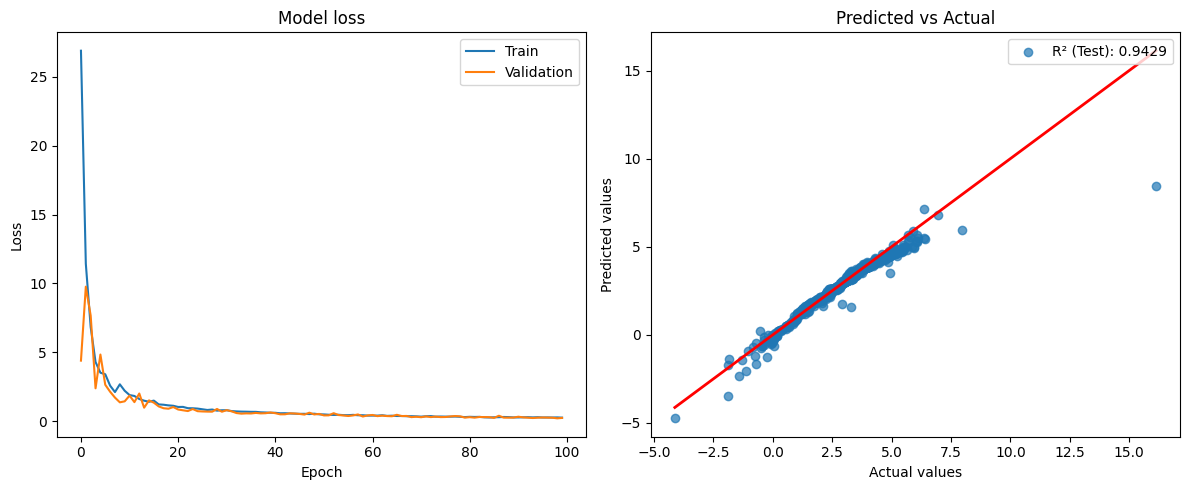

In [188]:
# Predict on the testing set
y_test_pred = model.predict(X_test)

# Calculate R² score
r2_test = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Mean Absolute Error (MAE): {mae}')

print(f'R² score for testing set: {r2_test:.4f}')

#Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')


# Plot predicted vs actual values
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Predicted vs Actual')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend([f'R² (Test): {r2_test:.4f}'], loc='upper right')

plt.tight_layout()
plt.show()

In [189]:
testset=np.array(y_test)
testset.shape

predicted_line = y_test_pred
predicted_line.shape

lets_see=np.reshape(predicted_line, (848,))

comparison_df = pd.DataFrame({'Actual Voltage': y_test.round(2), 'Predicted Voltage': lets_see.round(2)})
# comparison_df.set_index(battery_data['battery_'], inplace=True)
comparison_df.head(10)

,Actual Voltage,Predicted Voltage
3188,1.50,1.28
764,3.96,3.98
3264,4.87,4.76
1967,3.35,3.27
2185,4.73,4.42
393,3.36,3.27
2333,2.39,2.61
1159,4.49,4.05
3788,2.92,2.93
1674,3.23,3.28


In [ ]:
model.save('DNN_model2.h5')

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 168)               12768     
                                                                 
 dropout_11 (Dropout)        (None, 168)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                10816     
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23649 (92.38 KB)
Trainable params: 23649 (92.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from google.colab import files

# Download the model file
files.download('DNN_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###RANDOM FOREST###

In [138]:
# Train the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [139]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.14995099644743998
R-squared (R²): 0.9080384838949278


In [ ]:
# comparison_df = pd.DataFrame({'Actual Voltage': y_test, 'Predicted Voltage': y_pred})
# comparison_df.head()

,Actual Voltage,Predicted Voltage
3188,1.502793,1.663334
764,3.961299,3.981045
3264,4.873283,4.596031
1967,3.349825,3.610708
2185,4.733139,4.538949


In [140]:
# Use the TreeExplainer for Random Forests
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create a mapping of original feature names to new feature names
feature_name_mapping = {
    'energy_grav': 'Gravimetric Energy',
    'capacity_grav': 'Gravimetric Capacity',
    'capacity_vol': 'Volumetric Capacity',
    'avg_Mendeleev_Number': 'Average Mendeleev Number',
    'energy_vol': 'Volumetric Energy',
    'range_metallic_valence': 'Range of Metallic Valence',
    'working_ion_Zn': 'Working Ion',
    'band_gap_charge': 'Charged Band Gap',
    'avg_Atomic_Radius': 'Average Atomic Radius',
    'stability_discharge': 'Discharge Stability'
}
X_test_renamed = X_test.rename(columns=feature_name_mapping)

# For regression tasks, shap_values is a single array
shap_values = shap_values

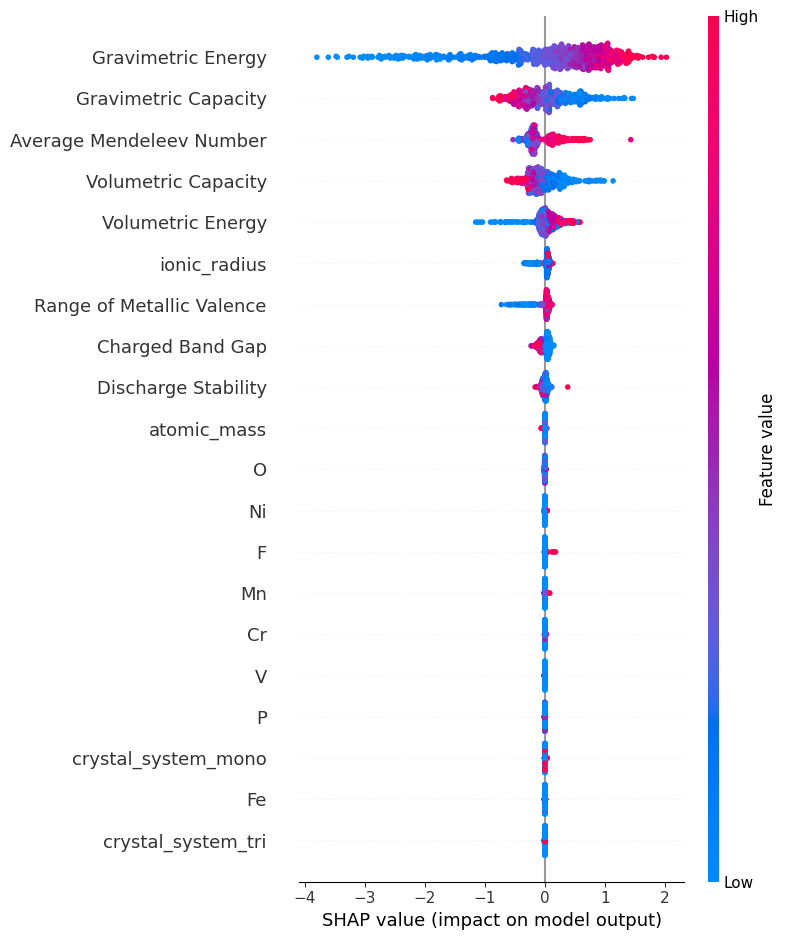

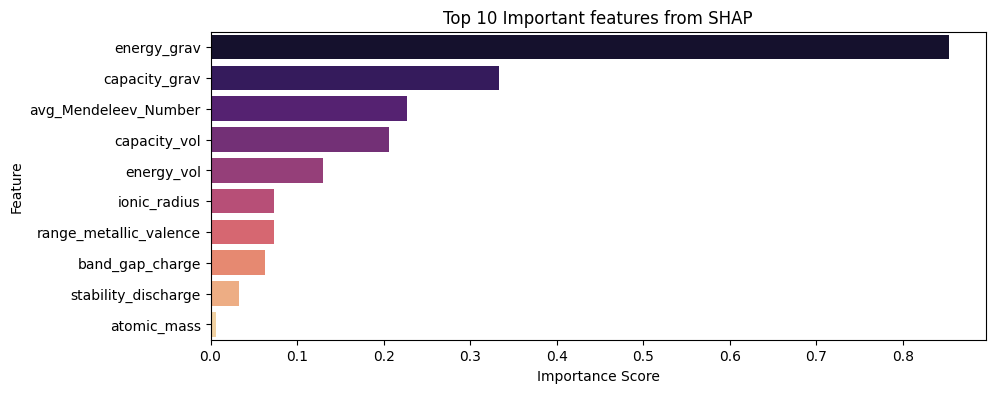

In [141]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_renamed)

# Calculate the mean absolute SHAP values for each feature
feature_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# Plotting the top 10 features with SHAP values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="magma")
plt.title('Top 10 Important features from SHAP')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()



###PREDICTIONS###

In [ ]:
model = tf.keras.models.load_model('DNN_model.h5')

In [191]:
column_order = composition_df.columns.tolist() + crystal_system_df.columns.tolist() + space_group_df.columns.tolist() + ['ionic_radius', 'atomic_mass','avg_Mendeleev_Number','range_metallic_valence',
       'energy_grav', 'capacity_grav', 'capacity_vol', 'energy_vol', 'band_gap_charge', 'stability_discharge']


# column_order = ['Co', 'Ni', 'O', 'Cr', 'Cu', 'Sb', 'P', 'H', 'Mn', 'V', 'Fe', 'S', 'In',
#        'Se', 'Ti', 'B', 'Ho', 'Si', 'Te', 'Ru', 'La', 'Er', 'Tl', 'W', 'F',
#        'Ge', 'C', 'Nb', 'Rh', 'Dy', 'Ga', 'Lu', 'Zn', 'Ta', 'Pt', 'Sn', 'Pb',
#        'Hg', 'Nd', 'Mo', 'Eu', 'Sm', 'Sc', 'N', 'Zr', 'Re', 'Y', 'As', 'Au',
#        'Bi', 'Cl', 'Al', 'Ag', 'Pd', 'Cd', 'Tb', 'Pr', 'Hf', 'U', 'Ir', 'Gd',
#        'I', 'Br', 'Ce', 'Tc', 'ionic_radius','avg_Mendeleev_Number', 'avg_Atomic_Radius', 'range_metallic_valence',
#        'energy_grav', 'capacity_grav', 'capacity_vol', 'energy_vol',
#        'band_gap_charge', 'stability_discharge']

In [192]:
def predict_average_voltage(input_df, feature_dict):
    input_df['ionic_radius'] = input_df['working_ion'].apply(get_ionic_radius)
    input_df['atomic_mass'] = input_df['working_ion'].apply(get_atomic_mass)

    crystal_system_encoded = encoder.fit_transform(input_df[['crystal_system']])
    crystal_system_df = pd.DataFrame(crystal_system_encoded.toarray(), columns=encoder.get_feature_names_out(['crystal_system']))

    space_group_encoded = encoder.fit_transform(input_df[['space_group']])
    space_group_df = pd.DataFrame(space_group_encoded.toarray(), columns=encoder.get_feature_names_out(['space_group']))

    # Parse the battery formula
    compositions = input_df['battery_formula'].apply(parse_formula)
    composition_df = pd.DataFrame(compositions.tolist()).fillna(0)

    # Create a DataFrame for the input features
    input_features = pd.DataFrame([feature_dict])


    # Combine with working ion and formula composition
    input_final = pd.concat([composition_df, crystal_system_df, space_group_df, input_df, input_features], axis=1).reindex(columns=column_order, fill_value=0)

    # Predict the average voltage
    prediction = model.predict(input_final)
    return prediction[0]


In [197]:
# Example usage
input_df = pd.DataFrame({'working_ion' : ['Y'],
'battery_formula': ['NiO2'],
'crystal_system': ['mono'], # Fixed typo here
'space_group': ['Pmmn']})
feature_dict = {
    'avg_Mendeleev_Number': -0.106308	,
    'avg_Atomic_Radius': 0.004583,
    'range_metallic_valence': 0.062134,
    'energy_grav': 1037.773008,
    'capacity_grav': 273.839389,
    'capacity_vol': 1348.509466,
    'energy_vol': 5110.465408,
    'band_gap_charge': 0.0000	,
    'stability_discharge': 0.000000
}
predicted_voltage = predict_average_voltage(input_df, feature_dict).round(2)
print(f'Predicted Average Voltage: {predicted_voltage}')

1/1 [==============================] - 0s 25ms/step
Predicted Average Voltage: [3.93]


In [149]:
battery_data['space_group']

0         C2/m
1         R-3m
2           Pm
3       Pna2_1
4           P1
         ...  
4233      Pmmn
4234        Cm
4235      C2/m
4236      R-3m
4237      P3m1
Name: space_group, Length: 4238, dtype: object

In [ ]:
# Load the dataset (assuming it's a CSV file)
df = pd.read_csv('battery_data.csv')
e_IDs = ["mp-22526_Li","mp-25210_Li","mp-1235941_Li","mp-2156_Li","mp-776288_Li"]

filtered_df = df[df['battery_id'].isin(e_IDs)]
filtered_df[['avg_Mendeleev_Number','avg_Atomic_Radius','range_metallic_valence','battery_id','battery_formula','formula_discharge','formula_charge','working_ion','energy_grav','capacity_grav','capacity_vol', 'energy_vol','band_gap_charge','stability_discharge','average_voltage']]

,avg_Mendeleev_Number,avg_Atomic_Radius,range_metallic_valence,battery_id,battery_formula,formula_discharge,formula_charge,working_ion,energy_grav,capacity_grav,capacity_vol,energy_vol,band_gap_charge,stability_discharge,average_voltage
1241,-0.106308,0.045450,-0.125921,mp-1235941_Li,Li0-1TiO2,LiTiO2,TiO2,Li,470.756630,308.748637,1155.315480,1761.537891,2.6004,0.085764,1.524725
1457,-0.003933,-0.002410,0.052979,mp-25210_Li,Li0-1NiO2,LiNiO2,NiO2,Li,1081.219395,274.511961,1285.571500,5063.476422,1.6001,0.000000,3.938697
1463,-0.050529,0.099117,-0.168907,mp-2156_Li,Li0-1TiS2,LiTiS2,TiS2,Li,422.570435,225.339935,696.682012,1306.458269,0.0000,0.000000,1.875258
2207,0.066546,-0.063692,0.069233,mp-776288_Li,Li0-1FePO4,LiFePO4,FePO4,Li,564.370967,169.890526,603.262446,2004.018814,1.6668,0.030257,3.321968
2353,-0.028738,0.004583,0.062134,mp-22526_Li,Li0-1CoO2,LiCoO2,CoO2,Li,1037.773008,273.839389,1348.509466,5110.465408,0.0000,0.000000,3.789714
